In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import joblib

# CONFIG
DATASET_DIR = 'dataset'  # This matches your folder name
OUTPUT_FILE = 'extracted_features.csv'

def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    img = cv2.resize(img, (128, 128))
    
    # 1. GLCM Features (Texture)
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    # 2. LBP Features (Patterns)
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-6) # Normalize
    
    # 3. Statistical Features
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    
    return [contrast, energy, correlation, homogeneity, mean_intensity, std_intensity] + list(lbp_hist)

data = []
labels = []
# Note: These folder names must match EXACTLY what is in your dataset folder
classes = ['notumor', 'glioma', 'meningioma', 'pituitary'] 

print("Extracting features... (This takes 2-3 minutes)")

for label, class_name in enumerate(classes):
    folder_path = os.path.join(DATASET_DIR, class_name)
    # Check if folder exists to avoid errors
    if not os.path.exists(folder_path):
        print(f"ERROR: Could not find folder {folder_path}")
        continue
        
    for file_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file_name)
        feats = extract_features(img_path)
        if feats:
            data.append(feats)
            labels.append(label)

# Save to CSV so we can verify it
col_names = ['Contrast', 'Energy', 'Correlation', 'Homogeneity', 'Mean', 'Std'] + [f'LBP_{i}' for i in range(10)]
df = pd.DataFrame(data, columns=col_names)
df['Label'] = labels
df.to_csv(OUTPUT_FILE, index=False)
print(f"SUCCESS! Features extracted to {OUTPUT_FILE}")
print(f"Total images processed: {len(df)}")

Extracting features... (This takes 2-3 minutes)
SUCCESS! Features extracted to extracted_features.csv
Total images processed: 7023


Training Models...
Training SVM...
  -> Accuracy: 57.94%
Training RandomForest...
  -> Accuracy: 90.68%
Training KNN...
  -> Accuracy: 73.24%
Training NaiveBayes...
  -> Accuracy: 61.35%
Training XGBoost...


c:\users\asham\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [08:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  -> Accuracy: 90.53%


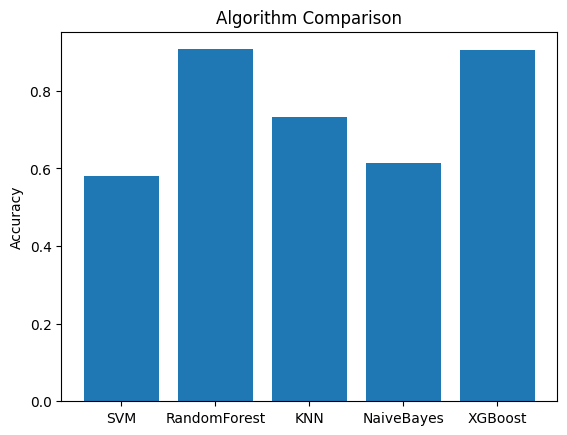

All models saved in 'models/' folder!


In [2]:
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load Data
df = pd.read_csv('extracted_features.csv')
X = df.drop('Label', axis=1)
y = df['Label']

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define 5 Models
# Define 5 Models (Optimized for Speed)
models = {
    
    'SVM': SVC(kernel='rbf', probability=True, cache_size=1000), 
    
    'RandomForest': RandomForestClassifier(n_estimators=100, n_jobs=-1), # n_jobs=-1 uses all CPU cores
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'NaiveBayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

# Ensure models folder exists
if not os.path.exists('models'): os.makedirs('models')

print("Training Models...")
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    # Save the model file
    joblib.dump(model, f'models/{name}.pkl')
    print(f"  -> Accuracy: {acc*100:.2f}%")

# Save feature names for the website to use
joblib.dump(list(X.columns), 'models/feature_names.pkl')

# Show a graph for your report
plt.bar(results.keys(), results.values())
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy')
plt.show()

print("All models saved in 'models/' folder!")